# Fine-tune masked ruBERT-tiny2

Загружаем библиотеки

In [2]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer, AutoModel
from datasets import Dataset
import evaluate

Загружаем отобранные предложения. Предложения отбираются в скрипте precorrect.py

In [3]:
with open('CorrectDN.json', encoding="utf-8") as f:
    sentences = pd.read_json(f, orient='records')
sentences.tail()

text  label
2931  Эксперт: морги Харькова переполнены телами укр...      1
2932  "Архитектор антироссийских санкций" возвращает...      1
2933  В Минздраве рассказали о состоянии пострадавши...      1
2934  Стало известно, какое оружие Украина захотела ...      1
2935  Евросоюз сократил закупки нефти и газа из Росс...      1

Собираем dataset

In [4]:
raw_ds = Dataset.from_pandas(sentences, preserve_index=False)
raw_ds = raw_ds.class_encode_column('label')
raw_ds.features

Stringifying the column:   0%|          | 0/2936 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2936 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['1'], id=None)}

Делим dataset на train и test (80:20)

In [5]:
raw_ds = raw_ds.train_test_split(test_size=0.2, shuffle=True)

In [6]:
from transformers import AutoModelForMaskedLM, AutoTokenizer

model_checkpoint = "cointegrated/rubert-tiny2"
# model_checkpoint = "DeepPavlov/rubert-base-cased"
# model_checkpoint = "ai-forever/ruBert-base"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [7]:
text = "После начала российской военной [MASK] на Украине западные страны усилили санкционное давление на Москву."

In [8]:
import torch

inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits
#print (inputs)
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
# print (mask_token_index)
mask_token_logits = token_logits[0, mask_token_index, :]

# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

word = "спецоперации"
iii = tokenizer(word, return_tensors="pt")
masked_token = iii["input_ids"][0][1].item()
print("Masked token id: ", tokenizer.mask_token_id)
print ("Masked token: ", masked_token)

probs = torch.nn.functional.softmax(mask_token_logits, dim=1)

print ("Probability of masked token: ", probs[0][masked_token])

top_5_prob = torch.topk(probs, 5, dim=1)
val = top_5_prob.values[0].tolist()
ind = top_5_prob.indices[0].tolist()
for i in range(len(val)):
    print (f"'>>> {tokenizer.decode([ind[i]])} ({ind[i]})  >>>>: {val[i]}")
print ("-----------------")



# for i in range(len(val_all)):
#     if ind[i] == 17627:
#         print (f"'>>> {tokenizer.decode([ind_all[i]])}  >>>>: {val_all[i]}")

#for token in top_5_tokens:
#    print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}' {token}")

Masked token id:  4
Masked token:  61407
Probability of masked token:  tensor(7.5576e-07, grad_fn=<SelectBackward0>)
'>>> службы (10969)  >>>>: 0.10426755994558334
'>>> операции (11394)  >>>>: 0.083821140229702
'>>> политики (17480)  >>>>: 0.07973532378673553
'>>> силы (11885)  >>>>: 0.06277793645858765
'>>> кампании (22938)  >>>>: 0.047023434191942215
-----------------


In [9]:
import re

s = "Как говорится в сообщении, Маск сможет оспорить соответствующее решение в следующей инстанции, а судья, постановившая, что повестку требуется исполнить, изменила свою позицию на рекомендательную."
maskToken = "[MASK]"
p = re.compile(r'[\w-]+')
iter = p.finditer(s)
nw = 0
hit = 0
for match in iter:
    nw += 1
    if match.start() == 0:
        masktext = maskToken + s[match.end():]
    elif match.end() == len(s):
        masktext = s[:match.start()] + maskToken
    else:
        masktext = s[:match.start()] + maskToken + s[match.end():]
    inputs = tokenizer(masktext, return_tensors="pt")
    token_logits = model(**inputs).logits
    # Find the location of [MASK] and extract its logits
    mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
    mask_token_logits = token_logits[0, mask_token_index, :]
    # Pick the [MASK] candidates with the highest logits
    top_1_tokens = torch.topk(mask_token_logits, 1, dim=1).indices[0].tolist()
   
    mt = tokenizer(match.group(), return_tensors="pt")
    masked_token = mt["input_ids"][0][1].item()
    if masked_token == top_1_tokens[0]:
        hit += 1
ratio = 1-hit/nw
print("Ratio: ", ratio)



Ratio:  0.7083333333333333


Tokenized dataset

In [10]:
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

# Use batched=True to activate fast multithreading!
tokenized_datasets = raw_ds.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)
tokenized_datasets

Map:   0%|          | 0/2348 [00:00<?, ? examples/s]

Map:   0%|          | 0/588 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 2348
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 588
    })
})

(array([  1.,  15.,  95., 205., 289., 308., 294., 265., 234., 189., 115.,
         86.,  53.,  37.,  34.,  28.,  18.,  18.,  15.,  10.,   8.,   8.,
          2.,   0.,   6.,   1.,   4.,   0.,   1.,   0.,   2.,   1.,   1.,
          0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([   3. ,   37.7,   72.4,  107.1,  141.8,  176.5,  211.2,  245.9,
         280.6,  315.3,  350. ,  384.7,  419.4,  454.1,  488.8,  523.5,
         558.2,  592.9,  627.6,  662.3,  697. ,  731.7,  766.4,  801.1,
         835.8,  870.5,  905.2,  939.9,  974.6, 1009.3, 1044. , 1078.7,
        1113.4, 1148.1, 1182.8, 1217.5, 1252.2, 1286.9, 1321.6, 1356.3,
        1391. , 1425.7, 1460.4, 1495.1, 1529.8, 1564.5, 1599.2, 1633.9,
        1668.6, 1703.3, 1738. ]),
 <BarContainer object of 50 artists>)

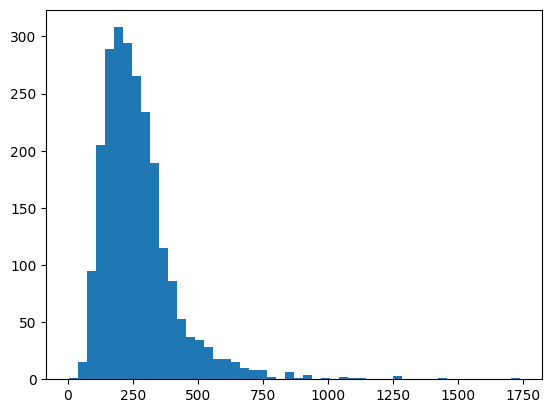

In [11]:
from matplotlib import pyplot as plt
# Slicing produces a list of lists for each feature
tokenized_samples = tokenized_datasets["train"]
lenlist = []
for idx, sample in enumerate(tokenized_samples["input_ids"]):
    lenlist.append(len(sample))
fig, ax = plt.subplots()
ax.hist(lenlist, 50)

Chank size (Parameter!!!)

In [12]:
chunk_size = 256

In [13]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [14]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)

print (lm_datasets["test"])
print (lm_datasets["test"]["input_ids"])
print (lm_datasets["test"]["token_type_ids"])
print (lm_datasets["test"]["attention_mask"])
print (lm_datasets["test"]["word_ids"])
print (lm_datasets["test"]["labels"])

Map:   0%|          | 0/2348 [00:00<?, ? examples/s]

Map:   0%|          | 0/588 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
    num_rows: 622
})
[[2, 282, 47330, 11783, 13267, 9886, 29766, 322, 59692, 83065, 1373, 548, 31447, 16908, 18, 36216, 41254, 55693, 16, 685, 28045, 887, 17, 31721, 31016, 18, 45705, 1439, 11783, 10510, 30092, 12068, 69746, 29766, 326, 37348, 56003, 36823, 322, 45782, 644, 55934, 59692, 83065, 1373, 548, 21, 31447, 16908, 16, 29819, 31721, 31016, 314, 29676, 17, 20727, 13418, 18, 6, 36499, 13267, 314, 11783, 6, 16, 17, 32969, 314, 32938, 18, 32240, 25409, 314, 29766, 626, 326, 37348, 56003, 36823, 314, 31059, 21, 33237, 16908, 36085, 39511, 6, 50016, 6967, 19425, 59129, 6, 18, 30451, 1218, 769, 22309, 322, 54301, 16, 17969, 40545, 48255, 769, 46209, 18, 29798, 43875, 29766, 43820, 314, 39093, 21115, 6414, 11783, 10510, 16, 1363, 1142, 34423, 24396, 322, 54301, 16, 11381, 16, 1150, 38107, 314, 46860, 16, 6, 21229, 326, 2079, 16, 1046, 38821, 59692, 83065, 603, 37022, 548, 3848, 3050, 39093,

Процент маскирования = 15% (Parameter!!!)

In [15]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

whole word masking, процент маскирования = 15% (Parameter!!!)

In [16]:
import collections
import numpy as np

from transformers import default_data_collator

wwm_probability = 0.15


def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id
        feature["labels"] = new_labels

    return default_data_collator(features)

Маскирование всего набора за раз

In [17]:
def insert_random_mask(batch):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

In [18]:
lm_datasets = lm_datasets.remove_columns(["word_ids"])
eval_dataset = lm_datasets["test"].map(
    insert_random_mask,
    batched=True,
    remove_columns=lm_datasets["test"].column_names,
)
eval_dataset = eval_dataset.rename_columns(
    {
        "masked_input_ids": "input_ids",
        "masked_attention_mask": "attention_mask",
        "masked_labels": "labels",
        "masked_token_type_ids": "token_type_ids"
    }
)
eval_dataset
print (eval_dataset["input_ids"])
print (eval_dataset["attention_mask"])
print (eval_dataset["labels"])
print (eval_dataset["token_type_ids"])

Map:   0%|          | 0/622 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


[[2, 4, 4, 11783, 13267, 65932, 29766, 322, 59692, 83065, 1373, 4, 77571, 16908, 18, 36216, 41254, 55693, 4, 685, 28045, 887, 17, 31721, 31016, 18, 4, 1439, 11783, 10510, 30092, 12068, 69746, 4, 326, 37348, 56003, 36823, 322, 45782, 644, 55934, 59692, 83065, 1373, 4, 4, 31447, 16908, 16, 29819, 31721, 31016, 4, 29676, 17, 20727, 13418, 18, 6, 36499, 13267, 4, 11783, 6, 16, 4, 32969, 314, 4, 18, 32240, 4, 314, 29766, 4, 326, 37348, 56003, 36823, 4, 31059, 21, 33237, 4, 36085, 39511, 6, 50016, 4, 19425, 59129, 4, 18, 30451, 1218, 4, 22309, 4, 54301, 16, 17969, 40545, 4, 769, 46209, 18, 29798, 43875, 29766, 43820, 314, 39093, 21115, 6414, 11783, 10510, 16, 4, 1142, 34423, 24396, 322, 4, 56121, 11381, 16, 1150, 38107, 314, 46860, 16, 6, 21229, 326, 2079, 16, 1046, 38821, 59692, 83065, 4, 37022, 4, 3848, 4, 39093, 25956, 613, 16, 37392, 16, 4, 3200, 24330, 21229, 326, 22234, 31465, 548, 3848, 37328, 45710, 3131, 4, 6, 4, 63831, 10985, 10164, 36241, 69358, 54111, 4352, 4, 2506, 2412, 320, 21

inputs_ids содержит маскированные данные (токен маски = 4), labels содержит токены под маской

Batch_size (Parameter!!!)

In [19]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

batch_size = 16
train_dataloader = DataLoader(
    lm_datasets["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
    # collate_fn=whole_word_masking_data_collator
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=batch_size, collate_fn=default_data_collator
)

LOSS function definition

In [21]:
import torch
import torch.nn as nn


i = 0
cross_entropy_loss = nn.CrossEntropyLoss(reduction='none')

for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)
        # print (tokenizer.decode([batch["labels"][0][7].item()]))
        # probs = nn.functional.softmax(outputs.logits[0][7], dim=-1)
        # print (probs[batch["labels"][0][7].item()])

        print ("Loss: ", outputs.loss)
        # print (outputs.logits.shape)
        # print (batch["labels"].shape)
        # ooo = torch.topk(outputs.logits, k=1, dim=2)
        # print (ooo.values.shape)
        # print (ooo.indices.shape)
        print (outputs.logits.view(-1, tokenizer.vocab_size).shape)
        print (batch["labels"].view(-1).shape)
        loss2 = cross_entropy_loss(outputs.logits.view(-1, tokenizer.vocab_size), batch["labels"].view(-1))
        print ("Loss2: ", loss2)
        print (tokenizer.vocab_size)

        # print (cel)
        i += 1
        if i == 1:
            break

Loss:  tensor(3.2220)
torch.Size([4096, 83828])
torch.Size([4096])
Loss2:  tensor(1971.8606)
83828


Optimizer (Parameter!!!)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
output_dir = 'fine-train'

In [ ]:
from tqdm.auto import tqdm
import torch
import math

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        losses.append(accelerator.gather(loss.repeat(batch_size)))

    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")

    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)